In [1]:
import os

# Dataset root path
data_dir = '/kaggle/input/ptb-xl-a-large-scale-ecg/ptb-xl-a-large-publicly-available-electrocardiography-dataset-1.0.3'

# List to store all file paths
all_files = []

# Walk through every folder and subfolder
for root, dirs, files in os.walk(data_dir):
    for f in files:
        file_path = os.path.join(root, f)
        all_files.append(file_path)

# Show total number of files
print(f"✅ Total files found: {len(all_files)}")

# Show a few sample file paths
print("\n📂 Example file paths:")
for i, path in enumerate(all_files[:15]):
    print(f"{i+1}. {path}")

# Optional: summary by folder (robust version)
folder_summary = {}
for f in all_files:
    relative_path = os.path.dirname(f).replace(data_dir, '').strip(os.sep)
    parts = relative_path.split(os.sep)
    folder = parts[0] if len(parts) > 0 and parts[0] != '' else "root"
    folder_summary[folder] = folder_summary.get(folder, 0) + 1

print("\n📊 File count by top-level folder:")
for k, v in folder_summary.items():
    print(f"{k:20s} : {v}")

✅ Total files found: 87204

📂 Example file paths:
1. /kaggle/input/ptb-xl-a-large-scale-ecg/ptb-xl-a-large-publicly-available-electrocardiography-dataset-1.0.3/SHA256SUMS.txt
2. /kaggle/input/ptb-xl-a-large-scale-ecg/ptb-xl-a-large-publicly-available-electrocardiography-dataset-1.0.3/RECORDS
3. /kaggle/input/ptb-xl-a-large-scale-ecg/ptb-xl-a-large-publicly-available-electrocardiography-dataset-1.0.3/example_physionet.py
4. /kaggle/input/ptb-xl-a-large-scale-ecg/ptb-xl-a-large-publicly-available-electrocardiography-dataset-1.0.3/ptbxl_v103_changelog.txt
5. /kaggle/input/ptb-xl-a-large-scale-ecg/ptb-xl-a-large-publicly-available-electrocardiography-dataset-1.0.3/scp_statements.csv
6. /kaggle/input/ptb-xl-a-large-scale-ecg/ptb-xl-a-large-publicly-available-electrocardiography-dataset-1.0.3/ptbxl_database.csv
7. /kaggle/input/ptb-xl-a-large-scale-ecg/ptb-xl-a-large-publicly-available-electrocardiography-dataset-1.0.3/LICENSE.txt
8. /kaggle/input/ptb-xl-a-large-scale-ecg/ptb-xl-a-large-publ

In [2]:
# === Step 0: Install required library ===
!pip install wfdb

# === Step 1: Import libraries ===
import os
import pandas as pd
import numpy as np
import wfdb
import ast
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import torch

# === Step 2: Define ECG data loader ===
def load_raw_data(df, sampling_rate, path):
    """
    Load ECG signals from PTB-XL dataset.
    Returns a NumPy array of shape (n_samples, n_timesteps, n_leads)
    """
    file_col = 'filename_lr' if sampling_rate == 100 else 'filename_hr'
    data = [wfdb.rdsamp(os.path.join(path, f))[0] for f in df[file_col]]
    return np.array(data)

# === Step 3: Setup dataset path and sampling rate ===
path = '/kaggle/input/ptb-xl-a-large-scale-ecg/ptb-xl-a-large-publicly-available-electrocardiography-dataset-1.0.3/'
sampling_rate = 100  # 100 Hz

# === Step 4: Load metadata and SCP codes ===
Y = pd.read_csv(os.path.join(path, 'ptbxl_database.csv'), index_col='ecg_id')
Y['scp_codes'] = Y['scp_codes'].apply(lambda x: ast.literal_eval(x))

# === Step 5: Load ECG signal data ===
print("Loading ECG signal data...")
X = load_raw_data(Y, sampling_rate, path)
print(f"✅ Loaded {len(X)} ECG samples.")

# === Step 6: Load SCP statements and keep only diagnostic ones ===
agg_df = pd.read_csv(os.path.join(path, 'scp_statements.csv'), index_col=0)
agg_df = agg_df[agg_df['diagnostic'] == 1]  # keep only diagnostic statements

# === Step 7: Map SCP codes to diagnostic superclass ===
def aggregate_diagnostic(y_dic):
    tmp = []
    for key in y_dic.keys():
        if key in agg_df.index:
            tmp.append(agg_df.loc[key].diagnostic_class)
    return list(set(tmp))

Y['diagnostic_superclass'] = Y['scp_codes'].apply(aggregate_diagnostic)

# === Step 8: Keep only single-label ECGs ===
mask = Y['diagnostic_superclass'].apply(lambda x: len(x) == 1)
Y_filtered = Y[mask].copy()
X_filtered = X[mask.values]  # align signals

# === Step 9: Convert label list to string ===
Y_filtered['diagnostic_superclass'] = Y_filtered['diagnostic_superclass'].apply(lambda x: x[0])

X_train_full, X_test, y_train_full, y_test = train_test_split(
    X_filtered, Y_filtered['diagnostic_superclass'],
    test_size=0.20,   # 20% test
    random_state=42,
    stratify=Y_filtered['diagnostic_superclass']
)

# Split 10% of the training set as validation
val_fraction = 0.10  # 10% of training
X_train, X_val, y_train, y_val = train_test_split(
    X_train_full, y_train_full,
    test_size=val_fraction,
    random_state=42,
    stratify=y_train_full
)
# === Step 11: Encode labels ===
le = LabelEncoder()
y_train_enc = le.fit_transform(y_train)
y_val_enc   = le.transform(y_val)
y_test_enc  = le.transform(y_test)

# === Step 12: Convert to tensors for PyTorch ===
X_train_tensor = torch.tensor(np.array(X_train), dtype=torch.float32)
y_train_tensor = torch.tensor(y_train_enc, dtype=torch.long)
X_val_tensor   = torch.tensor(np.array(X_val), dtype=torch.float32)
y_val_tensor   = torch.tensor(y_val_enc, dtype=torch.long)
X_test_tensor  = torch.tensor(np.array(X_test), dtype=torch.float32)
y_test_tensor  = torch.tensor(y_test_enc, dtype=torch.long)

# === Step 13: Summary ===
print("\n✅ Split Summary:")
print(f"Train: {len(X_train)} samples ({len(X_train)/len(X_filtered):.2%})")
print(f"Validation: {len(X_val)} samples ({len(X_val)/len(X_filtered):.2%})")
print(f"Test: {len(X_test)} samples ({len(X_test)/len(X_filtered):.2%})")

print("\n📊 Label distribution:")
print("Train:\n", pd.Series(y_train).value_counts(), "\n")
print("Validation:\n", pd.Series(y_val).value_counts(), "\n")
print("Test:\n", pd.Series(y_test).value_counts())

print("\n✅ Tensors ready for training:")
print(f"X_train: {X_train_tensor.shape}, y_train: {y_train_tensor.shape}")
print(f"X_val: {X_val_tensor.shape}, y_val: {y_val_tensor.shape}")
print(f"X_test: {X_test_tensor.shape}, y_test: {y_test_tensor.shape}")


Loading ECG signal data...
✅ Loaded 21799 ECG samples.

✅ Split Summary:
Train: 11695 samples (72.00%)
Validation: 1300 samples (8.00%)
Test: 3249 samples (20.00%)

📊 Label distribution:
Train:
 diagnostic_superclass
NORM    6529
MI      1823
STTC    1728
CD      1230
HYP      385
Name: count, dtype: int64 

Validation:
 diagnostic_superclass
NORM    726
MI      203
STTC    192
CD      136
HYP      43
Name: count, dtype: int64 

Test:
 diagnostic_superclass
NORM    1814
MI       506
STTC     480
CD       342
HYP      107
Name: count, dtype: int64

✅ Tensors ready for training:
X_train: torch.Size([11695, 1000, 12]), y_train: torch.Size([11695])
X_val: torch.Size([1300, 1000, 12]), y_val: torch.Size([1300])
X_test: torch.Size([3249, 1000, 12]), y_test: torch.Size([3249])


In [3]:
!pip install lightly

Epoch [1/50] Train=0.4830 Val=0.2780
Epoch [2/50] Train=0.2637 Val=0.2448
Epoch [3/50] Train=0.2597 Val=0.2491
Epoch [4/50] Train=0.2472 Val=0.2489
Epoch [5/50] Train=0.2480 Val=0.2311
Epoch [6/50] Train=0.2489 Val=0.2428
Epoch [7/50] Train=0.2362 Val=0.2149
Epoch [8/50] Train=0.2096 Val=0.2129
Epoch [9/50] Train=0.2075 Val=0.1836
Epoch [10/50] Train=0.1972 Val=0.1619
Epoch [11/50] Train=0.1728 Val=0.1744
Epoch [12/50] Train=0.1586 Val=0.1410
Epoch [13/50] Train=0.1476 Val=0.1179
Epoch [14/50] Train=0.1356 Val=0.1298
Epoch [15/50] Train=0.1317 Val=0.1331
Epoch [16/50] Train=0.1282 Val=0.1257
Epoch [17/50] Train=0.1205 Val=0.1436
Epoch [18/50] Train=0.1119 Val=0.1032
Epoch [19/50] Train=0.1009 Val=0.1043
Epoch [20/50] Train=0.0959 Val=0.0859
Epoch [21/50] Train=0.0890 Val=0.0802
Epoch [22/50] Train=0.0872 Val=0.0770
Epoch [23/50] Train=0.0747 Val=0.0865
Epoch [24/50] Train=0.0714 Val=0.0733
Epoch [25/50] Train=0.0658 Val=0.0505
Epoch [26/50] Train=0.0564 Val=0.0595
Epoch [27/50] Train=0

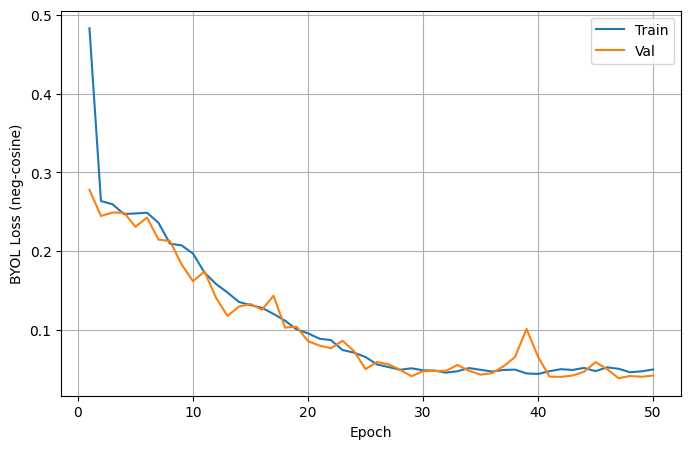

✅ BYOL pretraining completed & saved


In [4]:
# =========================================================
# Pure PyTorch BYOL for ECG (ResNet-1D)
# =========================================================
import os
import copy
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# ---------------- CONFIG ----------------
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
BATCH_SIZE = 64
EPOCHS = 50
LR = 1e-3
OUT_DIR = "byol_ckpts"
os.makedirs(OUT_DIR, exist_ok=True)
MOMENTUM = 0.996   # target ema

# =========================================================
# AUGMENTATIONS (same style as yours)
# =========================================================
class ECGTransform:
    def __init__(self, jitter=0.03, scale=0.1, mask_prob=0.05, drop_channel_prob=0.1):
        self.jitter = jitter
        self.scale = scale
        self.mask_prob = mask_prob
        self.drop_channel_prob = drop_channel_prob

    def jitter_fn(self, x):
        return x + torch.randn_like(x) * self.jitter

    def scale_fn(self, x):
        # scalar multiplier per sample
        return x * (1 + self.scale * torch.randn(1).to(x.device).item())

    def mask_fn(self, x):
        return x * (~(torch.rand_like(x) < self.mask_prob))

    def channel_dropout_fn(self, x):
        # x shape: (C, T) -> mask per channel
        mask = (torch.rand(x.size(0)) < self.drop_channel_prob).float().unsqueeze(1).to(x.device)
        return x * (1 - mask)

    def __call__(self, x):
        # x can be numpy or tensor with shape (C, T)
        if isinstance(x, np.ndarray):
            x = torch.tensor(x, dtype=torch.float32)
        else:
            x = x.clone().detach().float()

        # ensure at least 12 channels
        if x.shape[0] != 12:
            x = x[:12]

        x1, x2 = x.clone(), x.clone()
        for fn in [self.jitter_fn, self.scale_fn, self.mask_fn, self.channel_dropout_fn]:
            x1 = fn(x1)
            x2 = fn(x2)

        return x1, x2

# =========================================================
# DATASET
# =========================================================
class ECGDataset(Dataset):
    def __init__(self, signals, transform):
        # signals: np array or torch tensor (N, C, T)
        self.signals = signals
        self.transform = transform

    def __len__(self):
        return len(self.signals)

    def __getitem__(self, idx):
        x = self.signals[idx]  # (C, T)
        return self.transform(x)

# =========================================================
# RESNET-1D BACKBONE (same as yours)
# =========================================================
class BasicBlock1D(nn.Module):
    expansion = 1
    def __init__(self, in_planes, planes, stride=1):
        super().__init__()
        self.conv1 = nn.Conv1d(in_planes, planes, 3, stride, 1, bias=False)
        self.bn1 = nn.BatchNorm1d(planes)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv1d(planes, planes, 3, 1, 1, bias=False)
        self.bn2 = nn.BatchNorm1d(planes)

        self.downsample = nn.Sequential()
        if stride != 1 or in_planes != planes:
            self.downsample = nn.Sequential(
                nn.Conv1d(in_planes, planes, 1, stride, bias=False),
                nn.BatchNorm1d(planes)
            )

    def forward(self, x):
        out = self.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.downsample(x)
        return self.relu(out)

class ResNet1D(nn.Module):
    def __init__(self, layers=[3,4,6,3], in_channels=12, feat_dim=256):
        super().__init__()
        self.in_planes = 64
        self.conv1 = nn.Conv1d(in_channels, 64, 7, 2, 3, bias=False)
        self.bn1 = nn.BatchNorm1d(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool1d(3, 2, 1)

        self.layer1 = self._make_layer(64, layers[0])
        self.layer2 = self._make_layer(128, layers[1], stride=2)
        self.layer3 = self._make_layer(256, layers[2], stride=2)
        self.layer4 = self._make_layer(512, layers[3], stride=2)

        self.avgpool = nn.AdaptiveAvgPool1d(1)
        self.fc = nn.Linear(512, feat_dim)

    def _make_layer(self, planes, blocks, stride=1):
        layers = [BasicBlock1D(self.in_planes, planes, stride)]
        self.in_planes = planes
        for _ in range(1, blocks):
            layers.append(BasicBlock1D(self.in_planes, planes))
        return nn.Sequential(*layers)

    def forward(self, x):
        # x shape: (B, C, T)
        x = self.relu(self.bn1(self.conv1(x)))
        x = self.maxpool(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = self.avgpool(x).squeeze(-1)   # (B, 512)
        return nn.functional.normalize(self.fc(x), dim=1)  # (B, feat_dim)

# =========================================================
# Projector + Predictor (MLP heads)
# =========================================================
class MLPHead(nn.Module):
    def __init__(self, in_dim, hidden_dim=512, out_dim=256):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(in_dim, hidden_dim),
            nn.BatchNorm1d(hidden_dim),
            nn.ReLU(inplace=True),
            nn.Linear(hidden_dim, out_dim)
        )
    def forward(self, x):
        return self.net(x)

class Predictor(nn.Module):
    def __init__(self, in_dim=256, hidden_dim=512, out_dim=256):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(in_dim, hidden_dim),
            nn.BatchNorm1d(hidden_dim),
            nn.ReLU(inplace=True),
            nn.Linear(hidden_dim, out_dim)
        )
    def forward(self, x):
        return self.net(x)

# =========================================================
# BYOL wrapper
# =========================================================
class BYOL(nn.Module):
    def __init__(self, backbone, feat_dim=256, proj_hidden=512, pred_hidden=512, m=MOMENTUM):
        super().__init__()
        # online encoder & heads
        self.online_backbone = backbone
        self.online_projector = MLPHead(feat_dim, proj_hidden, feat_dim)
        self.predictor = Predictor(feat_dim, pred_hidden, feat_dim)

        # target encoder & projector (EMA copies)
        self.target_backbone = copy.deepcopy(self.online_backbone)
        self.target_projector = copy.deepcopy(self.online_projector)

        self._set_requires_grad(self.target_backbone, False)
        self._set_requires_grad(self.target_projector, False)

        self.m = m

    def _set_requires_grad(self, module, val):
        for p in module.parameters():
            p.requires_grad = val

    def forward(self, x1, x2):
        # x1, x2: (B, C, T)
        # online branch
        y1 = self.online_backbone(x1)       # (B, feat)
        z1 = self.online_projector(y1)      # (B, feat)
        p1 = self.predictor(z1)             # (B, feat)

        y2 = self.online_backbone(x2)
        z2 = self.online_projector(y2)
        p2 = self.predictor(z2)

        # target branch (no grad)
        with torch.no_grad():
            t_y1 = self.target_backbone(x1)
            t_z1 = self.target_projector(t_y1)
            t_y2 = self.target_backbone(x2)
            t_z2 = self.target_projector(t_y2)

        return p1, p2, t_z1.detach(), t_z2.detach()

    @torch.no_grad()
    def update_momentum(self, m=None):
        # EMA update target params: param_t = m * param_t + (1-m) * param_o
        if m is None:
            m = self.m
        for param_o, param_t in zip(self.online_backbone.parameters(), self.target_backbone.parameters()):
            param_t.data = param_t.data * m + param_o.data * (1. - m)
        for param_o, param_t in zip(self.online_projector.parameters(), self.target_projector.parameters()):
            param_t.data = param_t.data * m + param_o.data * (1. - m)

# =========================================================
# BYOL loss (negative cosine similarity variant)
# =========================================================
def byol_loss(p, z):
    # both: (B, D)
    p = nn.functional.normalize(p, dim=1)
    z = nn.functional.normalize(z, dim=1)
    # negative cosine similarity (we want to minimize)
    return 2 - 2 * (p * z).sum(dim=1).mean()

# =========================================================
# LOAD DATA (you must define X_train_tensor, X_val_tensor)
# Example for testing:
# X_train_tensor = torch.randn(1024,12,5000)
# X_val_tensor   = torch.randn(256,12,5000)
# =========================================================
# Make sure X_train_tensor and X_val_tensor exist in scope
try:
    X_train_tensor
    X_val_tensor
except NameError:
    raise RuntimeError("You must provide X_train_tensor and X_val_tensor as torch tensors of shape (N,12,T)")

train_dataset = ECGDataset(X_train_tensor.numpy(), ECGTransform())
val_dataset   = ECGDataset(X_val_tensor.numpy(), ECGTransform())

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)
val_loader   = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)

# =========================================================
# Build model & optimizer (only online params)
# =========================================================
backbone = ResNet1D()   # default feat_dim=256
byol_model = BYOL(backbone, feat_dim=256, proj_hidden=512, pred_hidden=512, m=MOMENTUM).to(DEVICE)

# Only optimize online parameters (backbone, projector, predictor)
opt_params = list(byol_model.online_backbone.parameters()) + \
             list(byol_model.online_projector.parameters()) + \
             list(byol_model.predictor.parameters())
optimizer = optim.Adam(opt_params, lr=LR)

# =========================================================
# TRAIN LOOP
# =========================================================
history = {"epoch": [], "train_loss": [], "val_loss": []}

for epoch in range(EPOCHS):
    byol_model.train()
    train_loss, seen = 0.0, 0

    for x1, x2 in train_loader:
        # x1,x2 shapes: (B, C, T) after collate
        x1 = x1.to(DEVICE)
        x2 = x2.to(DEVICE)

        p1, p2, z1_t, z2_t = byol_model(x1, x2)

        loss1 = byol_loss(p1, z2_t)
        loss2 = byol_loss(p2, z1_t)
        loss = 0.5 * (loss1 + loss2)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # EMA update of target networks
        byol_model.update_momentum()

        train_loss += loss.item() * x1.size(0)
        seen += x1.size(0)

    avg_train = train_loss / seen

    # -------------- VALIDATION --------------
    byol_model.eval()
    val_loss, seen = 0.0, 0
    with torch.no_grad():
        for x1, x2 in val_loader:
            x1 = x1.to(DEVICE)
            x2 = x2.to(DEVICE)
            p1, p2, z1_t, z2_t = byol_model(x1, x2)
            loss1 = byol_loss(p1, z2_t)
            loss2 = byol_loss(p2, z1_t)
            loss = 0.5 * (loss1 + loss2)
            val_loss += loss.item() * x1.size(0)
            seen += x1.size(0)

    avg_val = val_loss / seen

    history["epoch"].append(epoch+1)
    history["train_loss"].append(avg_train)
    history["val_loss"].append(avg_val)

    print(f"Epoch [{epoch+1}/{EPOCHS}] Train={avg_train:.4f} Val={avg_val:.4f}")

    # ---------- SAVE CKPT ----------
    torch.save({
        "epoch": epoch+1,
        "online_backbone": byol_model.online_backbone.state_dict(),
        "online_projector": byol_model.online_projector.state_dict(),
        "predictor": byol_model.predictor.state_dict(),
        "target_backbone": byol_model.target_backbone.state_dict(),
        "target_projector": byol_model.target_projector.state_dict(),
        "optimizer": optimizer.state_dict()
    }, f"{OUT_DIR}/byol_epoch_{epoch+1}.pth")

# =========================================================
# SAVE & PLOT
# =========================================================
df = pd.DataFrame(history)
df.to_csv(f"{OUT_DIR}/byol_loss_history.csv", index=False)

plt.figure(figsize=(8,5))
plt.plot(history["epoch"], history["train_loss"], label="Train")
plt.plot(history["epoch"], history["val_loss"], label="Val")
plt.xlabel("Epoch")
plt.ylabel("BYOL Loss (neg-cosine)")
plt.legend()
plt.grid()
plt.savefig(f"{OUT_DIR}/byol_train_val_loss.png", dpi=150)
plt.show()

print("✅ BYOL pretraining completed & saved")


In [7]:
# =========================================================
# BYOL Downstream Classification (Stacked pipeline)
# =========================================================

import os, time, joblib
import numpy as np
import pandas as pd
import torch
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler, LabelEncoder, label_binarize
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score, roc_curve
from sklearn.model_selection import train_test_split

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
OUT_DIR = "byol_downstream"
os.makedirs(OUT_DIR, exist_ok=True)
BATCH_SIZE = 64

# =========================================================
# Load pretrained BYOL backbone (must define ResNet1D)
# =========================================================
backbone = ResNet1D(layers=[3,4,6,3], in_channels=12, feat_dim=256)
ckpt = torch.load("byol_ckpts/byol_epoch_50.pth", map_location=DEVICE)
backbone.load_state_dict(ckpt["online_backbone"])
backbone.to(DEVICE)
backbone.eval()
print("✅ Loaded BYOL backbone")

# =========================================================
# Feature extraction function
# =========================================================
@torch.no_grad()
def extract_features(X_tensor, batch_size=64):
    feats = []
    for i in range(0, len(X_tensor), batch_size):
        x = X_tensor[i:i+batch_size]
        if x.shape[1] != 12:  # permute if needed
            x = x.permute(0, 2, 1)
        x = x.to(DEVICE)
        f = backbone(x)
        feats.append(f.cpu().numpy())
    return np.vstack(feats)

# =========================================================
# Prepare full dataset tensors (train + val + test)
# X_train_tensor, X_val_tensor, X_test_tensor must exist
# =========================================================
X_all_tensor = torch.cat([X_train_tensor, X_val_tensor, X_test_tensor], dim=0)
y_all_tensor = torch.cat([y_train_tensor, y_val_tensor, y_test_tensor], dim=0)
print("Full dataset tensor shape:", X_all_tensor.shape)

# =========================================================
# Extract features using BYOL backbone
# =========================================================
t0 = time.time()
X_feat = extract_features(X_all_tensor, batch_size=BATCH_SIZE)
y_raw = y_all_tensor.numpy()
print(f"✅ Features extracted: {X_feat.shape}, time: {time.time()-t0:.2f}s")

# Save raw features & labels
np.save(os.path.join(OUT_DIR, "features.npy"), X_feat)
pd.Series(y_raw).to_csv(os.path.join(OUT_DIR, "labels.csv"), index=False)

# =========================================================
# Encode labels
# =========================================================
le = LabelEncoder()
y_enc = le.fit_transform(y_raw)
class_names = [str(c) for c in le.classes_]
n_classes = len(class_names)

# =========================================================
# Train/Test split (80/20)
# =========================================================
X_train, X_test, y_train, y_test = train_test_split(
    X_feat, y_enc, test_size=0.2, stratify=y_enc, random_state=42
)

# =========================================================
# Scale features
# =========================================================
scaler = StandardScaler()
X_train_s = scaler.fit_transform(X_train)
X_test_s = scaler.transform(X_test)
joblib.dump(scaler, os.path.join(OUT_DIR, "scaler.joblib"))

# =========================================================
# Define classifiers
# =========================================================
models = {
    "LogisticRegression": LogisticRegression(max_iter=2000, multi_class='multinomial'),
    "SVM": SVC(kernel="linear", probability=True),
    "DecisionTree": DecisionTreeClassifier(),
    "RandomForest": RandomForestClassifier(n_estimators=200)
}

results = []

for name, clf in models.items():
    print(f"\nTraining {name}...")
    clf.fit(X_train_s, y_train)

    y_pred = clf.predict(X_test_s)
    acc = accuracy_score(y_test, y_pred)
    print(f"Accuracy: {acc:.4f}")
    print(classification_report(y_test, y_pred, target_names=class_names, zero_division=0))

    # ROC & AUC
    macro_auc = np.nan
    if hasattr(clf, "predict_proba"):
        y_prob = clf.predict_proba(X_test_s)
        y_test_bin = label_binarize(y_test, classes=np.arange(n_classes))
        macro_auc = roc_auc_score(y_test_bin, y_prob, average="macro", multi_class="ovr")

        # Plot ROC for LR + SVM
        if name in ["LogisticRegression", "SVM"]:
            plt.figure(figsize=(8,6))
            for i, cname in enumerate(class_names):
                if y_test_bin[:,i].sum() == 0: continue
                fpr, tpr, _ = roc_curve(y_test_bin[:,i], y_prob[:,i])
                plt.plot(fpr, tpr, label=cname)
            plt.plot([0,1],[0,1],'k--')
            plt.title(f"{name} ROC (macro AUC={macro_auc:.3f})")
            plt.xlabel("FPR"); plt.ylabel("TPR")
            plt.legend(fontsize="small")
            plt.grid(True)
            plt.tight_layout()
            plt.savefig(os.path.join(OUT_DIR, f"roc_{name.lower()}.png"), dpi=150)
            plt.close()

    # Save classifier
    joblib.dump(clf, os.path.join(OUT_DIR, f"{name.lower()}.joblib"))

    results.append({
        "model": name,
        "accuracy": acc,
        "macro_auc": macro_auc,
        "train_size": len(X_train),
        "test_size": len(X_test)
    })

# =========================================================
# Save summary
# =========================================================
summary_df = pd.DataFrame(results)
summary_df.to_csv(os.path.join(OUT_DIR, "summary.csv"), index=False)

print("\n✅ BYOL downstream evaluation completed")
print(summary_df)
print("\nSaved all results to:", OUT_DIR)


✅ Loaded BYOL backbone
Full dataset tensor shape: torch.Size([16244, 1000, 12])
✅ Features extracted: (16244, 256), time: 3.03s

Training LogisticRegression...
Accuracy: 0.6088
              precision    recall  f1-score   support

           0       0.67      0.23      0.34       342
           1       0.50      0.03      0.05       107
           2       0.45      0.16      0.24       506
           3       0.62      0.95      0.75      1814
           4       0.50      0.19      0.28       480

    accuracy                           0.61      3249
   macro avg       0.55      0.31      0.33      3249
weighted avg       0.58      0.61      0.54      3249


Training SVM...
Accuracy: 0.5756
              precision    recall  f1-score   support

           0       0.80      0.18      0.29       342
           1       0.00      0.00      0.00       107
           2       0.00      0.00      0.00       506
           3       0.57      1.00      0.73      1814
           4       0.00      

In [8]:
import os, time, joblib
import numpy as np
import pandas as pd
import torch
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler, LabelEncoder, label_binarize
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
OUT_DIR = "byol_downstream_stacking"
os.makedirs(OUT_DIR, exist_ok=True)
BATCH_SIZE = 64
backbone = ResNet1D(layers=[3,4,6,3], in_channels=12, feat_dim=256)
ckpt = torch.load("byol_ckpts/byol_epoch_50.pth", map_location=DEVICE)
backbone.load_state_dict(ckpt["online_backbone"])
backbone.to(DEVICE)
backbone.eval()
print("✅ Loaded BYOL backbone")
@torch.no_grad()
def extract_features(X_tensor, batch_size=64):
    feats = []
    for i in range(0, len(X_tensor), batch_size):
        x = X_tensor[i:i+batch_size]
        if x.shape[1] != 12:  # permute if needed
            x = x.permute(0, 2, 1)
        x = x.to(DEVICE)
        f = backbone(x)
        feats.append(f.cpu().numpy())
    return np.vstack(feats)
X_all_tensor = torch.cat([X_train_tensor, X_val_tensor, X_test_tensor], dim=0)
y_all_tensor = torch.cat([y_train_tensor, y_val_tensor, y_test_tensor], dim=0)

t0 = time.time()
X_feat = extract_features(X_all_tensor)
y_raw = y_all_tensor.numpy()
print(f"✅ Features extracted: {X_feat.shape}, time: {time.time()-t0:.2f}s")

# Save features
np.save(os.path.join(OUT_DIR, "features.npy"), X_feat)
pd.Series(y_raw).to_csv(os.path.join(OUT_DIR, "labels.csv"), index=False)
le = LabelEncoder()
y_enc = le.fit_transform(y_raw)
class_names = [str(c) for c in le.classes_]
n_classes = len(class_names)
X_train, X_test, y_train, y_test = train_test_split(
    X_feat, y_enc, test_size=0.2, stratify=y_enc, random_state=42
)
scaler = StandardScaler()
X_train_s = scaler.fit_transform(X_train)
X_test_s = scaler.transform(X_test)
joblib.dump(scaler, os.path.join(OUT_DIR, "scaler.joblib"))
base_models = {
    "LogisticRegression": LogisticRegression(max_iter=2000, multi_class='multinomial'),
    "SVM": SVC(kernel="linear", probability=True),
    "DecisionTree": DecisionTreeClassifier(),
    "RandomForest": RandomForestClassifier(n_estimators=200)
}

kf = KFold(n_splits=5, shuffle=True, random_state=42)
train_meta = np.zeros((X_train_s.shape[0], len(base_models)*n_classes))
test_meta = np.zeros((X_test_s.shape[0], len(base_models)*n_classes))

results_base = []

for i, (name, clf) in enumerate(base_models.items()):
    print(f"\nTraining base model: {name}")
    oof_pred = np.zeros((X_train_s.shape[0], n_classes))
    
    for train_idx, val_idx in kf.split(X_train_s):
        clf.fit(X_train_s[train_idx], y_train[train_idx])
        oof_pred[val_idx] = clf.predict_proba(X_train_s[val_idx])
    
    # Save base model
    clf.fit(X_train_s, y_train)
    joblib.dump(clf, os.path.join(OUT_DIR, f"{name.lower()}.joblib"))
    
    # Store predictions for stacking
    train_meta[:, i*n_classes:(i+1)*n_classes] = oof_pred
    test_meta[:, i*n_classes:(i+1)*n_classes] = clf.predict_proba(X_test_s)
    
    acc = accuracy_score(y_test, clf.predict(X_test_s))
    results_base.append({"model": name, "accuracy": acc})
    print(f"{name} test accuracy: {acc:.4f}")

meta_clf = LogisticRegression(max_iter=2000, multi_class='multinomial')
meta_clf.fit(train_meta, y_train)
y_pred_meta = meta_clf.predict(test_meta)
acc_meta = accuracy_score(y_test, y_pred_meta)
print("\n✅ Stacking ensemble accuracy:", acc_meta)
print(classification_report(y_test, y_pred_meta, target_names=class_names, zero_division=0))

# Save meta-classifier
joblib.dump(meta_clf, os.path.join(OUT_DIR, "meta_logistic.joblib"))

summary_df = pd.DataFrame(results_base)

# Create a new DataFrame row for stacking ensemble
stacking_row = pd.DataFrame([{
    "model": "Stacking_Ensemble",
    "accuracy": acc_meta
}])

# Concatenate
summary_df = pd.concat([summary_df, stacking_row], ignore_index=True)

summary_df.to_csv(os.path.join(OUT_DIR, "summary_stacking.csv"), index=False)
print("\n✅ Summary saved to CSV")
print(summary_df) 
 

✅ Loaded BYOL backbone
✅ Features extracted: (16244, 256), time: 2.99s

Training base model: LogisticRegression
LogisticRegression test accuracy: 0.6088

Training base model: SVM
SVM test accuracy: 0.5756

Training base model: DecisionTree
DecisionTree test accuracy: 0.3970

Training base model: RandomForest
RandomForest test accuracy: 0.5592

✅ Stacking ensemble accuracy: 0.6294244382887042
              precision    recall  f1-score   support

           0       0.65      0.26      0.37       342
           1       0.27      0.03      0.05       107
           2       0.45      0.25      0.32       506
           3       0.67      0.90      0.77      1814
           4       0.51      0.40      0.45       480

    accuracy                           0.63      3249
   macro avg       0.51      0.37      0.39      3249
weighted avg       0.60      0.63      0.59      3249



AttributeError: 'DataFrame' object has no attribute 'append'

In [11]:
summary_df = pd.DataFrame(results_base)

# Create a new DataFrame row for stacking ensemble
stacking_row = pd.DataFrame([{
    "model": "Stacking_Ensemble",
    "accuracy": acc_meta
}])

# Concatenate
summary_df = pd.concat([summary_df, stacking_row], ignore_index=True)

summary_df.to_csv(os.path.join(OUT_DIR, "summary_stacking.csv"), index=False)
print("\n✅ Summary saved to CSV")
print(summary_df)


✅ Summary saved to CSV
                model  accuracy
0  LogisticRegression  0.608803
1                 SVM  0.575562
2        DecisionTree  0.397045
3        RandomForest  0.559249
4   Stacking_Ensemble  0.629424


In [10]:

import os, joblib, time
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score, classification_report

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
OUT_DIR = "byol_stacking_mlp_downstream_fast"
os.makedirs(OUT_DIR, exist_ok=True)

# ---------------- Prepare Features -----------------
# X_feat, y_raw must exist from BYOL feature extraction
le = LabelEncoder()
y_enc = le.fit_transform(y_raw)
class_names = [str(c) for c in le.classes_]
n_classes = len(class_names)

X_train, X_test, y_train, y_test = train_test_split(
    X_feat, y_enc, test_size=0.2, stratify=y_enc, random_state=42
)

scaler = StandardScaler()
X_train_s = scaler.fit_transform(X_train)
X_test_s  = scaler.transform(X_test)
joblib.dump(scaler, os.path.join(OUT_DIR, "scaler.joblib"))

# ---------------- Base models -----------------
base_models = {
    "LogisticRegression": LogisticRegression(max_iter=1000, multi_class='multinomial', solver='saga', n_jobs=-1),
    "SVM": SVC(kernel="linear", probability=True),
    "DecisionTree": DecisionTreeClassifier(),
    "RandomForest": RandomForestClassifier(n_estimators=200, n_jobs=-1)
}

train_meta_features = []
test_meta_features = []

for name, clf in base_models.items():
    print(f"Training base model: {name} ...")
    clf.fit(X_train_s, y_train)
    joblib.dump(clf, os.path.join(OUT_DIR, f"{name.lower()}.joblib"))
    
    # Use predicted probabilities as meta-features
    if hasattr(clf, "predict_proba"):
        train_meta_features.append(clf.predict_proba(X_train_s))
        test_meta_features.append(clf.predict_proba(X_test_s))
    else:
        # fallback: one-hot encoding
        train_meta_features.append(np.eye(n_classes)[clf.predict(X_train_s)])
        test_meta_features.append(np.eye(n_classes)[clf.predict(X_test_s)])

X_train_meta = np.hstack(train_meta_features)
X_test_meta  = np.hstack(test_meta_features)

# ---------------- Optional: PCA to reduce dimension -----------------
pca = PCA(n_components=min(128, X_train_meta.shape[1]))
X_train_meta = pca.fit_transform(X_train_meta)
X_test_meta  = pca.transform(X_test_meta)
joblib.dump(pca, os.path.join(OUT_DIR, "pca_meta.joblib"))

# ---------------- MLP Meta-Classifier -----------------
class MetaMLP(nn.Module):
    def __init__(self, in_dim, hidden_dim=128, out_dim=n_classes):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(in_dim, hidden_dim),
            nn.BatchNorm1d(hidden_dim),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(hidden_dim, out_dim)
        )
    def forward(self, x):
        return self.net(x)

# Convert to tensors
X_train_meta_t = torch.tensor(X_train_meta, dtype=torch.float32).to(DEVICE)
y_train_t      = torch.tensor(y_train, dtype=torch.long).to(DEVICE)
X_test_meta_t  = torch.tensor(X_test_meta, dtype=torch.float32).to(DEVICE)
y_test_t       = torch.tensor(y_test, dtype=torch.long).to(DEVICE)

mlp_meta = MetaMLP(X_train_meta.shape[1]).to(DEVICE)
optimizer = optim.Adam(mlp_meta.parameters(), lr=1e-3, weight_decay=1e-4)
criterion = nn.CrossEntropyLoss()

# ---------------- Train MLP -----------------
EPOCHS = 50
for epoch in range(EPOCHS):
    mlp_meta.train()
    optimizer.zero_grad()
    logits = mlp_meta(X_train_meta_t)
    loss = criterion(logits, y_train_t)
    loss.backward()
    optimizer.step()
    
    if (epoch+1) % 10 == 0:
        pred = torch.argmax(logits, dim=1)
        acc = (pred == y_train_t).float().mean().item()
        print(f"Epoch {epoch+1}/{EPOCHS} - Train Loss: {loss.item():.4f} - Acc: {acc:.4f}")

# ---------------- Evaluate -----------------
mlp_meta.eval()
with torch.no_grad():
    logits_test = mlp_meta(X_test_meta_t)
    y_pred_test = torch.argmax(logits_test, dim=1).cpu().numpy()
    acc = accuracy_score(y_test, y_pred_test)
    print("\n✅ Stacking + MLP Downstream Accuracy:", acc)
    print(classification_report(y_test, y_pred_test, target_names=class_names, zero_division=0))

# Save meta-MLP
torch.save(mlp_meta.state_dict(), os.path.join(OUT_DIR, "mlp_meta.pth"))
print("Saved all base models, PCA, and meta-classifier to:", OUT_DIR)


Training base model: LogisticRegression ...


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Training base model: SVM ...
Training base model: DecisionTree ...
Training base model: RandomForest ...
Epoch 10/50 - Train Loss: 1.1791 - Acc: 0.7383
Epoch 20/50 - Train Loss: 0.6874 - Acc: 0.9871
Epoch 30/50 - Train Loss: 0.3845 - Acc: 0.9998
Epoch 40/50 - Train Loss: 0.2169 - Acc: 0.9999
Epoch 50/50 - Train Loss: 0.1283 - Acc: 0.9999

✅ Stacking + MLP Downstream Accuracy: 0.399507540781779
              precision    recall  f1-score   support

           0       0.20      0.22      0.21       342
           1       0.09      0.09      0.09       107
           2       0.20      0.21      0.21       506
           3       0.60      0.57      0.58      1814
           4       0.15      0.16      0.16       480

    accuracy                           0.40      3249
   macro avg       0.25      0.25      0.25      3249
weighted avg       0.41      0.40      0.41      3249

Saved all base models, PCA, and meta-classifier to: byol_stacking_mlp_downstream_fast


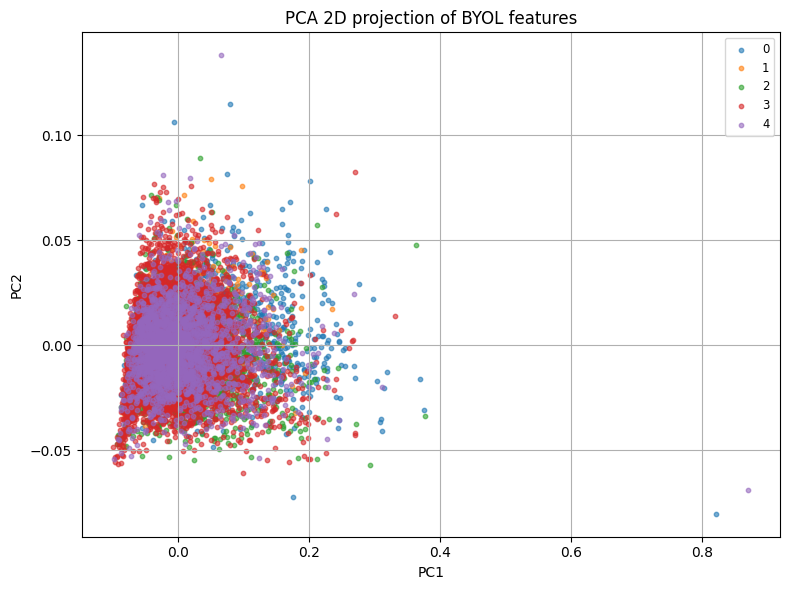

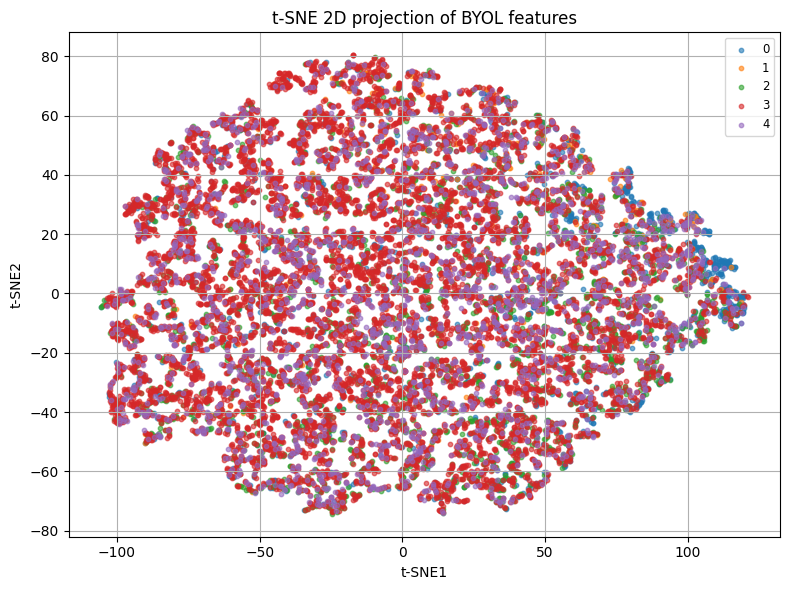

In [12]:

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
y_enc = le.fit_transform(y_raw)
class_names = [str(c) for c in le.classes_]
n_classes = len(class_names)

# ---------------- PCA 2D ----------------
pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(X_feat)

plt.figure(figsize=(8,6))
for i, cname in enumerate(class_names):
    idx = y_enc == i
    plt.scatter(X_pca[idx,0], X_pca[idx,1], label=cname, s=10, alpha=0.6)
plt.title("PCA 2D projection of BYOL features")
plt.xlabel("PC1"); plt.ylabel("PC2")
plt.legend(fontsize="small")
plt.grid(True)
plt.tight_layout()
plt.show()

# ---------------- t-SNE 2D ----------------
tsne = TSNE(n_components=2, perplexity=30, n_iter=1000, random_state=42, init='pca')
X_tsne = tsne.fit_transform(X_feat)

plt.figure(figsize=(8,6))
for i, cname in enumerate(class_names):
    idx = y_enc == i
    plt.scatter(X_tsne[idx,0], X_tsne[idx,1], label=cname, s=10, alpha=0.6)
plt.title("t-SNE 2D projection of BYOL features")
plt.xlabel("t-SNE1"); plt.ylabel("t-SNE2")
plt.legend(fontsize="small")
plt.grid(True)
plt.tight_layout()
plt.show()
